<div class="markdown-google-sans">
  <h3>Kiểm tra GPU được cấp phát</h3>
</div>

In [1]:
!nvidia-smi

Fri Mar  3 00:29:18 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 520.61.05    Driver Version: 520.61.05    CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:65:00.0 Off |                  N/A |
|  0%   56C    P8    35W / 370W |      1MiB / 24576MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:B3:00.0 Off |                  N/A |
|  0%   

<div class="markdown-google-sans">
  <h3>Cài đặt bổ sung một số thư viện</h3>
</div>
Nền tảng Google Colab cung cấp môi trường với các thư viện Machine Learning, Deep Learning cơ bản đã được cài đặt sẵn, phần này sẽ cài đặt một số thư viện sử dụng thêm.

In [ ]:
!pip install segmentation_models_pytorch
!pip install albumentations
!pip install transformers

<div class="markdown-google-sans">
  <h3>Import thư viện</h3>
</div>

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2 # np.array -> torch.tensor
import os
from tqdm import tqdm
from glob import glob
from torchvision.datasets import VOCSegmentation
import random

<div class="markdown-google-sans">
  <h3>Định nghĩa Dataset</h3>
</div>
Viết class kế thừa từ class Dataset cung cấp sẵn trong PyTorch để đọc dữ liệu từ ổ cứng. Yêu cầu viết đủ 3 hàm __init__() để khởi tạo class, __len__() để trả về số điểm dữ liệu có trong tập dữ liệu và __getitem__() trả về 1 điểm dữ liệu cụ thể. Trong phần này, do tập dữ liệu PASCAL VOC đã rất phổ biến nên sẽ tận dụng Class Dataset đã được viết sẵn. Tham khảo thêm: https://albumentations.ai/docs/autoalbument/examples/pascal_voc/


In [2]:
cv2.setNumThreads(0)
cv2.ocl.setUseOpenCL(False)

VOC_CLASSES = [
    "background",
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "motorbike",
    "person",
    "potted plant",
    "sheep",
    "sofa",
    "train",
    "tv/monitor",
]


VOC_COLORMAP = [
    [0, 0, 0],
    [128, 0, 0],
    [0, 128, 0],
    [128, 128, 0],
    [0, 0, 128],
    [128, 0, 128],
    [0, 128, 128],
    [128, 128, 128],
    [64, 0, 0],
    [192, 0, 0],
    [64, 128, 0],
    [192, 128, 0],
    [64, 0, 128],
    [192, 0, 128],
    [64, 128, 128],
    [192, 128, 128],
    [0, 64, 0],
    [128, 64, 0],
    [0, 192, 0],
    [128, 192, 0],
    [0, 64, 128],
]

class PascalVOCSearchDataset(VOCSegmentation):
    def __init__(self, root="~/data/pascal_voc", image_set="train", download=True, transform=None):
        super().__init__(root=root, image_set=image_set, download=download, transform=transform)

    @staticmethod
    def _convert_to_segmentation_mask(mask):
        # This function converts a mask from the Pascal VOC format to the format required by AutoAlbument.
        #
        # Pascal VOC uses an RGB image to encode the segmentation mask for that image. RGB values of a pixel
        # encode the pixel's class.
        #
        # AutoAlbument requires a segmentation mask to be a NumPy array with the shape [height, width, num_classes].
        # Each channel in this mask should encode values for a single class. Pixel in a mask channel should have
        # a value of 1.0 if the pixel of the image belongs to this class and 0.0 otherwise.
        height, width = mask.shape[:2]
        segmentation_mask = np.zeros((height, width, len(VOC_COLORMAP)), dtype=np.float32)
        for label_index, label in enumerate(VOC_COLORMAP):
            segmentation_mask[:, :, label_index] = np.all(mask == label, axis=-1).astype(float)
        return segmentation_mask #0, 1, 2, 3, ..., 20 (H, W, C) -> (H, W, 1) -> (H, W) #numpy

    def __getitem__(self, index):
        image = cv2.imread(self.images[index])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks[index])
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        mask = self._convert_to_segmentation_mask(mask)
        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]
        return image, mask.argmax(dim=2).squeeze() #torch.tensor

<div class="markdown-google-sans">
  <h3>Định nghĩa các phép augmentation trên ảnh</h3>
</div>
Sử dụng thư viện Albumentations, tham khảo thêm: https://albumentations.ai/docs/api_reference/full_reference/

In [3]:
trainsize = 256

train_transform = A.Compose([
    A.Resize(width=trainsize, height=trainsize),
    A.HorizontalFlip(),
    A.RandomBrightnessContrast(),
    A.Blur(),
    A.Sharpen(),
    A.RGBShift(),
    A.Cutout(num_holes=5, max_h_size=25, max_w_size=25, fill_value=0),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
    ToTensorV2(),
])

test_trainsform = A.Compose([
    A.Resize(width=trainsize, height=trainsize),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
    ToTensorV2(), # numpy.array -> torch.tensor (B, 3, H, W)
])

/home/bui.thanh.tung/miniconda3/envs/torch_seg/lib/python3.8/site-packages/albumentations/augmentations/dropout/cutout.py:49: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


<div class="markdown-google-sans">
  <h3>Đoạn code dùng để convert ảnh sau khi đã chuẩn hoá thành ảnh ban đầu</h3>
</div>

In [4]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
        
    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor
    
unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

<div class="markdown-google-sans">
  <h3>Kiểm tra 1 cặp ảnh đầu vào và ảnh kết quả phân vùng trước khi đưa vào mô hình training</h3>
</div>

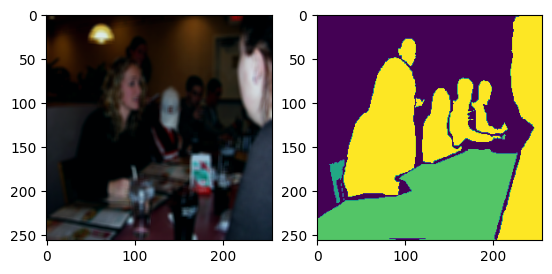

tensor([ 0,  9, 11, 15])


In [5]:
train_dataset = PascalVOCSearchDataset(image_set="train", download=False, transform=train_transform)
test_dataset = PascalVOCSearchDataset(image_set="val", download=False, transform=test_trainsform)

idx = random.randint(0, train_dataset.__len__())

image, mask = train_dataset.__getitem__(idx)
plt.subplot(1, 2, 1)
plt.imshow(unorm(image).permute(1, 2, 0))
plt.subplot(1, 2, 2)
plt.imshow(mask)
plt.show()
print(mask.unique())

<div class="markdown-google-sans">
  <h3>Tạo AverageMeter</h3>
</div>
AverageMeter có nhiệm vụ lưu lại giá trị trung bình của độ chính xác, giá trị hàm loss, ... trong suốt quá trình training. Tham khảo thêm: https://discuss.pytorch.org/t/meaning-of-parameters/10655

In [6]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

<div class="markdown-google-sans">
  <h3>Lập trình hàm tính toán độ chính xác dựa trên IoU và Dice</h3>
</div>
Tham khảo: https://github.com/hszhao/semseg/blob/master/util/util.py

In [7]:
#metrics
def intersectionAndUnionGPU(output, target, K, ignore_index=255):
    # 'K' classes, output and target sizes are N or N * L or N * H * W, each value in range 0 to K - 1.
    assert (output.dim() in [1, 2, 3])
    assert output.shape == target.shape
    output = output.view(-1)
    target = target.view(-1)
    output[target == ignore_index] = ignore_index
    intersection = output[output == target]
    area_intersection = torch.histc(intersection, bins=K, min=0, max=K-1)
    area_output = torch.histc(output, bins=K, min=0, max=K-1)
    area_target = torch.histc(target, bins=K, min=0, max=K-1)
    area_union = area_output + area_target - area_intersection
    return area_intersection, area_union, area_target 

<div class="markdown-google-sans">
  <h3>Chuẩn bị cho quá trình training</h3>
</div>


1.   Lựa chọn device: PyTorch yêu cầu lựa chọn cụ thể device sẽ train và yêu cầu người dùng tự move dữ liệu, mô hình vào device đã lựa chọn. Device có thể là "cuda" - tức là GPU NVIDIA hoặc "cpu".
2.   Định nghĩa DataLoader, khác với Dataset là cách đọc dữ liệu từ ổ cứng, DataLoader ghép nhiều điểm dữ liệu vào cùng nhau tạo thành 1 batch để đưa vào train mô hình. Lưu ý thêm: batch_size nên đặt là 4, 8, 16, 32, ... và nên để lớn nhất có thể
3.   Khởi tạo mô hình dùng thư viện HuggingFace/Transformers
4.   Khởi tạo hàm loss
5.   Khởi tạo thuật toán tối ưu (optimizer)
6.   Khởi tạo các độ đo sẽ sử dụng để đánh giá hiệu năng của mô hình. Phần này sẽ sử dụng các hàm độ đo Dice và IoU được lập trình sẵn trong thư viện torchmetrics
7.   Khởi tạo từng AverageMeter để lưu lại giá trị của từng độ đo, giá trị hàm loss, thời gian train, ... trong suốt quá trình train

In [8]:
#device
#!pip install transformers
from transformers import SegformerForSemanticSegmentation

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#load data
batch_size = 24
n_workers = os.cpu_count()
print("num_workers =", n_workers)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=n_workers)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False, num_workers=n_workers)

#model
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b4-finetuned-ade-512-512").to(device)

#loss
# criterion = smp.losses.DiceLoss(mode="multiclass", classes=21)
criterion = nn.CrossEntropyLoss()

#optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
n_eps = 15

#meter
train_loss_meter = AverageMeter()
intersection_meter = AverageMeter()
union_meter = AverageMeter()
target_meter = AverageMeter()

num_workers = 8


<div class="markdown-google-sans">
  <h3>Training thôi ...</h3>
</div>
Tham khảo thêm cách viết code training trong PyTorch: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

In [ ]:
for ep in range(1, 1+n_eps):
    train_loss_meter.reset()
    intersection_meter.reset()
    union_meter.reset()
    target_meter.reset()
    model.train()

    for batch_id, (x, y) in enumerate(tqdm(trainloader), start=1):
        optimizer.zero_grad()
        n = x.shape[0]
        x = x.to(device).float()
        y = y.to(device).long()
        y_hat = model(x).logits #(B, C, H, W)
        y_hat = F.interpolate(y_hat, y.shape[1:], mode="bilinear")
        loss = criterion(y_hat, y) #(B, C, H, W) >< (B, H, W)
        loss.backward()
        optimizer.step()

        #save metrics
        with torch.no_grad():
            train_loss_meter.update(loss.item())
            y_hat_mask = y_hat.argmax(dim=1).squeeze(1) # (B, C, H, W) -> (B, 1, H, W) -> (B, H, W)
            intersection, union, target = intersectionAndUnionGPU(y_hat_mask.float(), y.float(), 21)
            intersection_meter.update(intersection)
            union_meter.update(union)
            target_meter.update(target)

    #compute iou, dice
    with torch.no_grad():
        iou_class = intersection_meter.sum / (union_meter.sum + 1e-10) #vector 21D
        dice_class = (2 * intersection_meter.sum) / (intersection_meter.sum + union_meter.sum + 1e-10) #vector 21D

        mIoU = torch.mean(iou_class) #mean vector 21D
        mDice = torch.mean(dice_class) #mean vector 21D

    print("EP {}, train loss = {} IoU = {}, dice = {}".format(ep, train_loss_meter.avg, mIoU, mDice))
    
    if ep >= 40:
        torch.save(model.state_dict(), "modelFPN1_ep_{}.pth".format(ep))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:39<00:00,  1.53it/s]


EP 1, train loss = 2.2553182312699613 IoU = 0.049743007868528366, dice = 0.0709536224603653


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:38<00:00,  1.60it/s]


EP 2, train loss = 0.9436279378953527 IoU = 0.12834760546684265, dice = 0.19065913558006287


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:38<00:00,  1.60it/s]


EP 3, train loss = 0.6331157977463769 IoU = 0.2705835998058319, dice = 0.388491690158844


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:38<00:00,  1.59it/s]


EP 4, train loss = 0.43898681929854094 IoU = 0.4353543221950531, dice = 0.582341730594635


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:38<00:00,  1.59it/s]


EP 5, train loss = 0.3303663847876377 IoU = 0.5596336126327515, dice = 0.6999542117118835


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:38<00:00,  1.59it/s]


EP 6, train loss = 0.2742498551235824 IoU = 0.6190670728683472, dice = 0.7504180669784546


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:38<00:00,  1.59it/s]


EP 7, train loss = 0.22422152953069718 IoU = 0.6835653781890869, dice = 0.8015563488006592


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:38<00:00,  1.59it/s]


EP 8, train loss = 0.19492979249993309 IoU = 0.7199628353118896, dice = 0.8264026045799255


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:38<00:00,  1.60it/s]


EP 9, train loss = 0.17810227221152822 IoU = 0.7333475947380066, dice = 0.8365442156791687


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:38<00:00,  1.58it/s]


EP 10, train loss = 0.16521598264330722 IoU = 0.746581494808197, dice = 0.8466061353683472


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:38<00:00,  1.59it/s]


EP 11, train loss = 0.1460366357789665 IoU = 0.7763980031013489, dice = 0.8670908808708191


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:38<00:00,  1.59it/s]


EP 12, train loss = 0.14751851864036966 IoU = 0.7763290405273438, dice = 0.8674067854881287


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 57/61 [00:36<00:02,  1.77it/s]

<div class="markdown-google-sans">
  <h3>Viết code đưa ra kết quả trên tập dữ liệu test</h3>
</div>
Lưu ý: Trong quá trình test cần chuyển model về chế độ eval và nên đặt torch.no_grad(). Điểm khác nhau giữa model.eval() và torch.no_grad() là model.eval() sẽ đặt chế độ của mô hình về chế độ evaluation (thay đổi các layer như dropout, batch norm, ... khác với quá trình training) còn torch.no_grad() sẽ tắt tính toán đạo hàm của PyTorch để tiết kiệm tính toán. Do vậy khi test mô hình nên chú ý dùng cả 2 câu lệnh này.

In [10]:
model.eval()
test_intersection_meter = AverageMeter()
test_union_meter = AverageMeter()
test_target_meter = AverageMeter()
with torch.no_grad():
    for batch_id, (x, y) in enumerate(tqdm(testloader), start=1):
        n = x.shape[0]
        x = x.to(device).float()
        y = y.to(device).long()
        y_hat = model(x).logits
        y_hat = F.interpolate(y_hat, size=y.shape[1], mode="bilinear")
        y_hat = y_hat.squeeze(1)
        y_hat_mask = y_hat.argmax(dim=1)
        
        intersection, union, target = intersectionAndUnionGPU(y_hat_mask, y, 21)
        test_intersection_meter.update(intersection)
        test_union_meter.update(union)
        test_target_meter.update(target)
        
    iou_class = test_intersection_meter.sum / (test_union_meter.sum + 1e-10)
    dice_class = 2*test_intersection_meter.sum / (test_intersection_meter.sum + test_union_meter.sum + 1e-10)

    mIoU = torch.mean(iou_class)
    mDice = torch.mean(dice_class)
        
print("TEST: IoU = {}, dice = {}".format(mIoU, mDice))

100%|██████████| 91/91 [00:26<00:00,  3.41it/s]

TEST: IoU = 0.6618906855583191, dice = 0.7820723652839661


<div class="markdown-google-sans">
  <h3>Viết code hiển thị kết quả dự đoán</h3>
</div>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 0 14 15]
(256, 256)


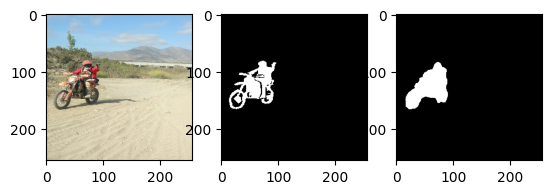

In [15]:
#predict
import random
id = random.randint(0, 1450)
with torch.no_grad():
    model.eval()
    x, y = test_dataset.__getitem__(id)
    y_predict = F.interpolate(model(x.unsqueeze(0).to(device)).logits, size=y.shape, mode="bilinear").argmax(dim=1).squeeze().cpu().numpy()
    print(np.unique(y_predict))
    print(y_predict.shape)
    color_mask_predict = np.zeros((*y_predict.shape, 3))
    for i, color in enumerate(VOC_COLORMAP):
        color_mask_predict[y_predict==i] = np.array(color)
    color_mask = np.zeros((*y_predict.shape, 3))
    for i, color in enumerate(VOC_COLORMAP):
        color_mask[y==i] = np.array(color)
    plt.subplot(1,3,1)
    plt.imshow(unorm(x).permute(1, 2, 0))
    plt.subplot(1,3,2)
    plt.imshow(color_mask)
    plt.subplot(1,3,3)
    plt.imshow(color_mask_predict)
    plt.show()